In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Isotonic Mechanism for Rating Before Rebuttal and proxy


Ad-hoc Isotonic Mechanism 1.4008721178514472
Review Rating 1.5893148577827474
Before Rebuttal with proxy t-test for greedy: 6.061712168536928
Before Rebuttal with proxy p-value for greedy: 7.222205266476588e-10


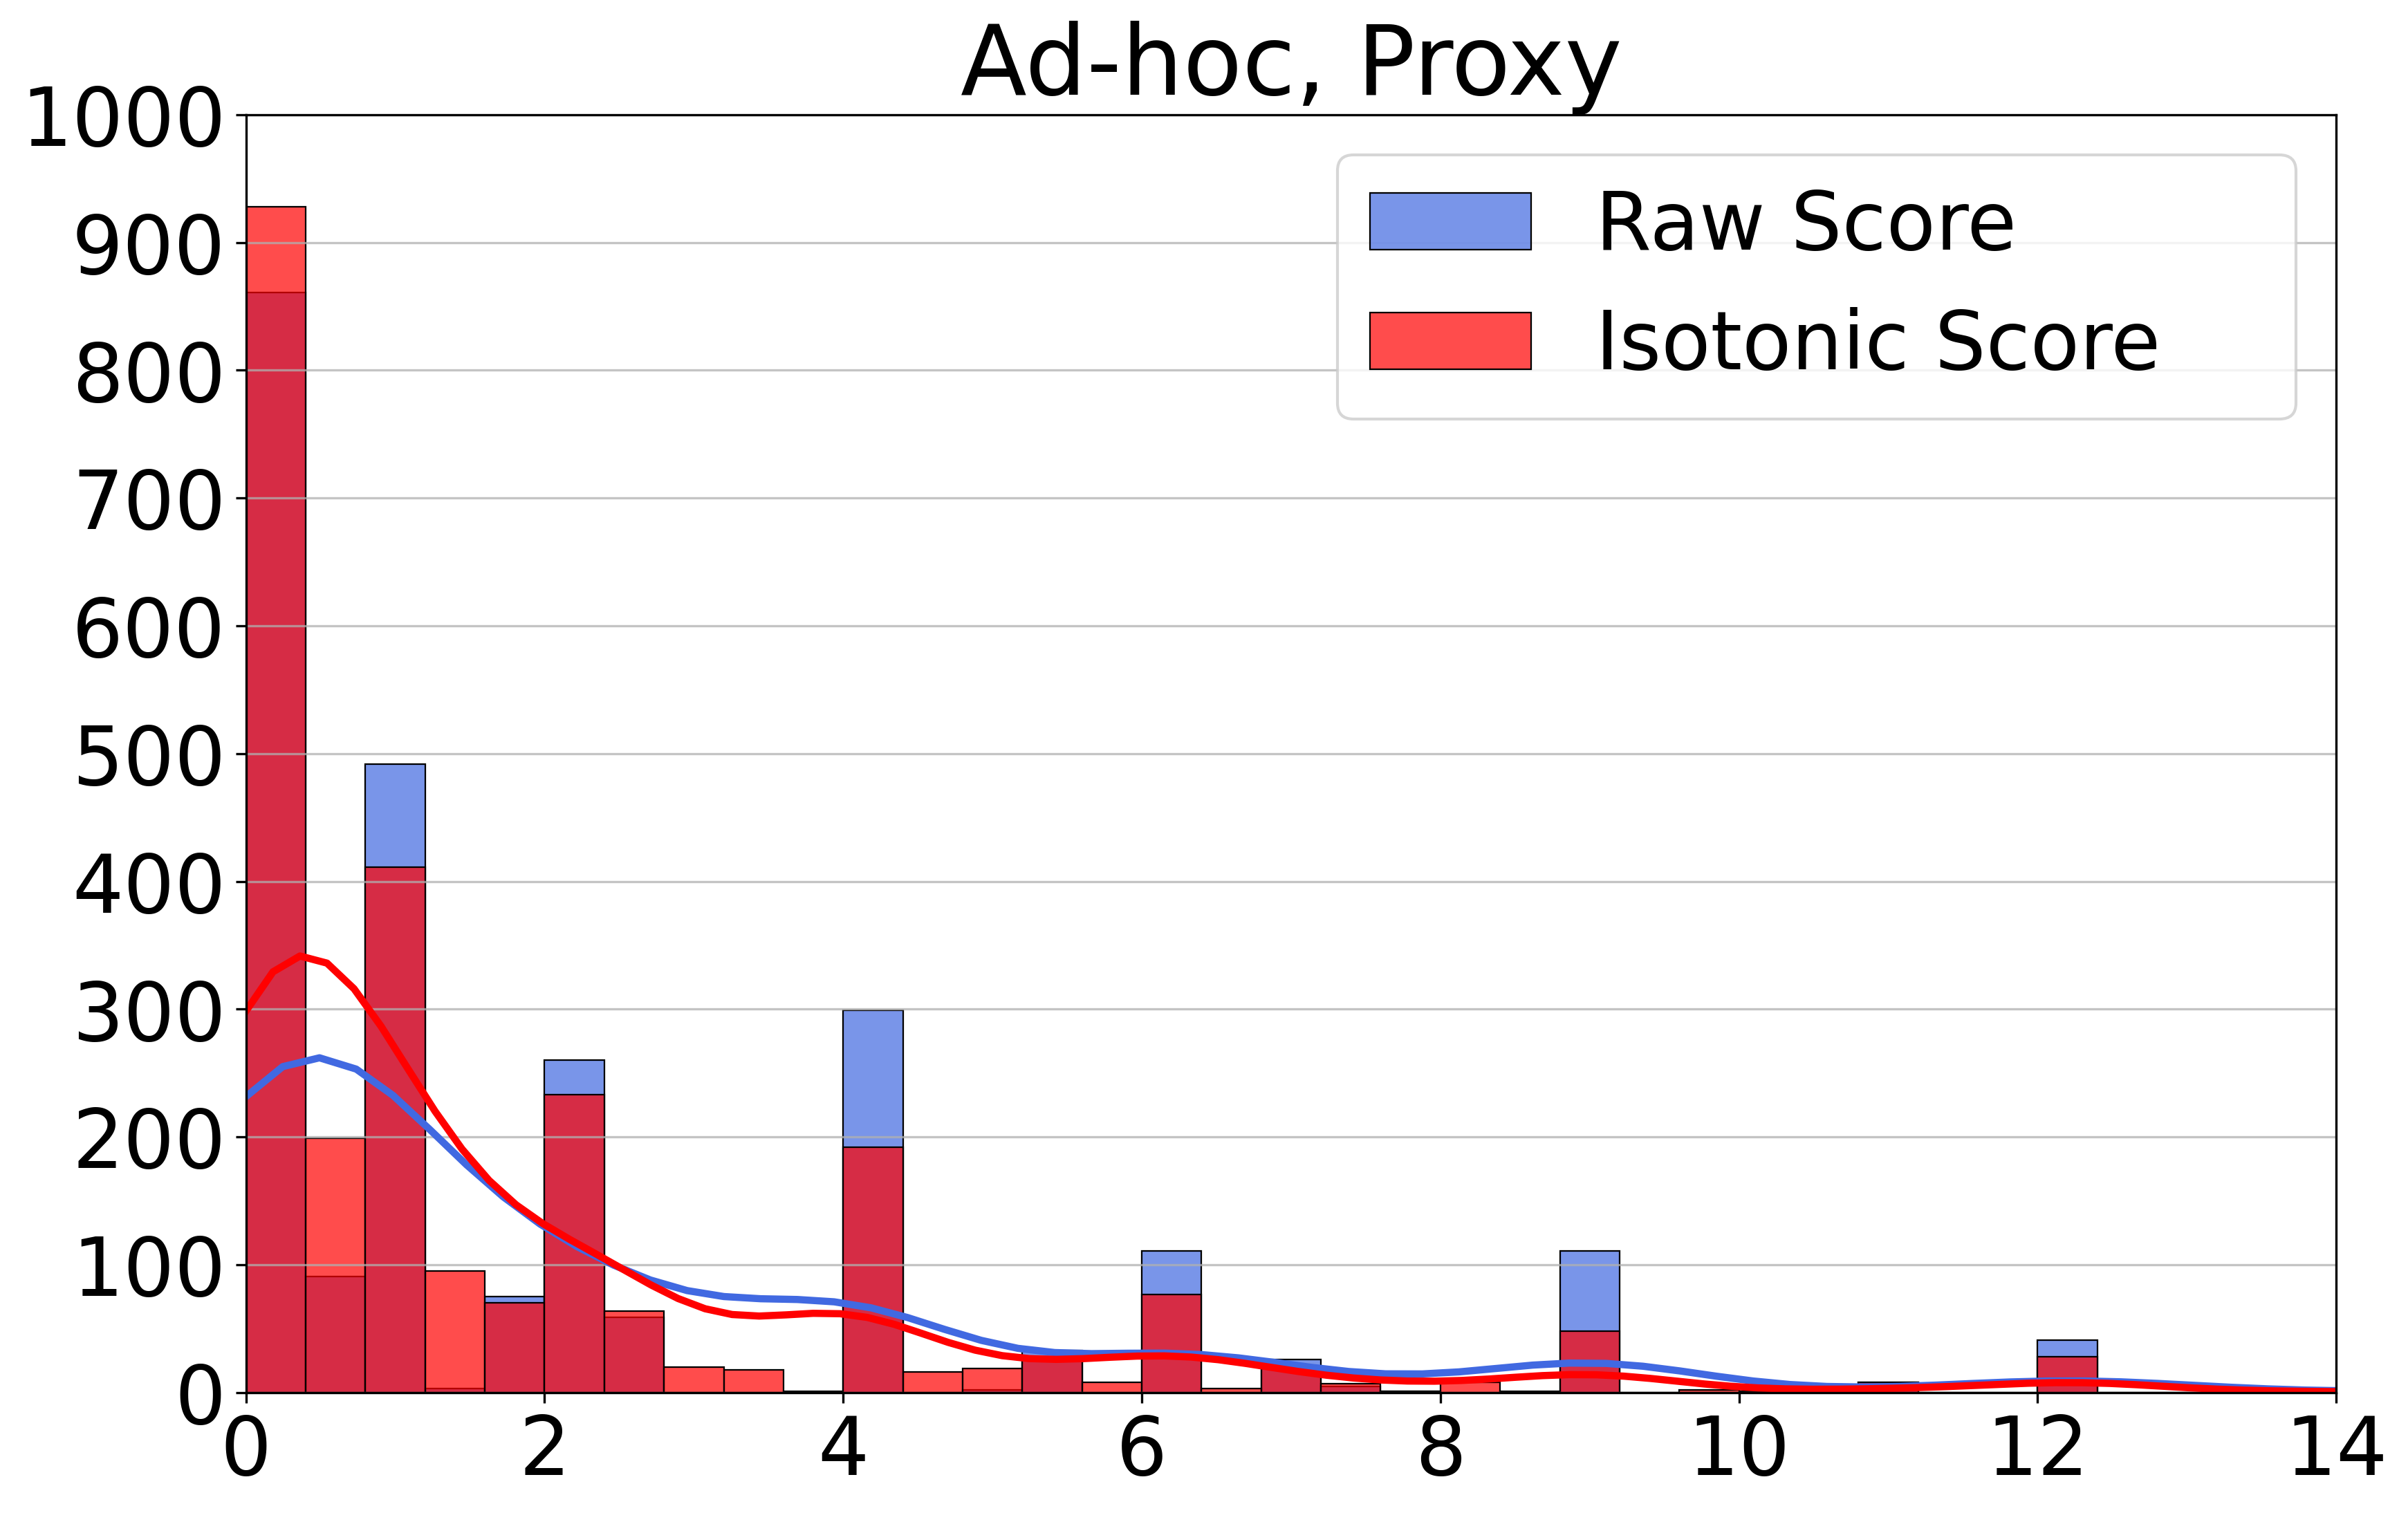

In [7]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 28
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch




# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])


# For each author, list its ranked submissions according to its ranking

author_submission_rank_old = {}

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()

# Loop through every submission
for author in authors:

    author_submission_rank_old[author] = []

    # Extract the rating as sets
    submissions = list(set(df[df['author_idx'] == author]['submission_idx'].tolist()))

    for i in range(len(submissions)):

        rank = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((submissions[i], rank, ratings))

def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

author_submission_rank_old = sort_submissions(author_submission_rank_old)



author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



final_submission_list = df['submission_idx'].unique()



submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    # Convert string numbers to float
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating



adhoc_iso_rating = []
for submission in final_submission_list:
  adhoc_iso_rating.append(submission_new_rating[submission])



submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]


True_score_multi_iso = []
for submission in final_submission_list:
    True_score_multi_iso.append(submission_true_rating[submission])



old_rating = {}
for submission in final_submission_list:
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for submission in final_submission_list:
    old_score_multi_iso.append(old_rating[submission])



print('Ad-hoc Isotonic Mechanism', mean_squared_error(adhoc_iso_rating, True_score_multi_iso, squared=False))
print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso, squared=False))



adhoc_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  adhoc_diff.append( (adhoc_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_ind(old_diff, adhoc_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)



# 做一个histogram
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=True, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
#sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Multi Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=adhoc_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Isotonic Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('(a) Squared Error')
plt.ylabel('')
plt.title('Ad-hoc, Proxy')
plt.xlim(0, 14)
plt.yticks(range(0, 1001, 100))
plt.legend()
plt.savefig('/content/drive/MyDrive/Research/Ranking_ICML/Figures/adhoc_iso_proxy_histo.svg', bbox_inches='tight')

# Show the plot
plt.show()

Greedy Isotonic Mechanism 1.404326296958069
Multiowner Isotonic Mechanism 1.4399807234468944
Review Rating 1.5893148577827474
Before Rebuttal with proxy t-test for greedy: 5.946878600160579
Before Rebuttal with proxy p-value for greedy: 1.4582578420085256e-09
Before Rebuttal with proxy t-test for multi-owner: 4.7787831023578065
Before Rebuttal with proxy p-value for multi-owner: 9.067592109218994e-07


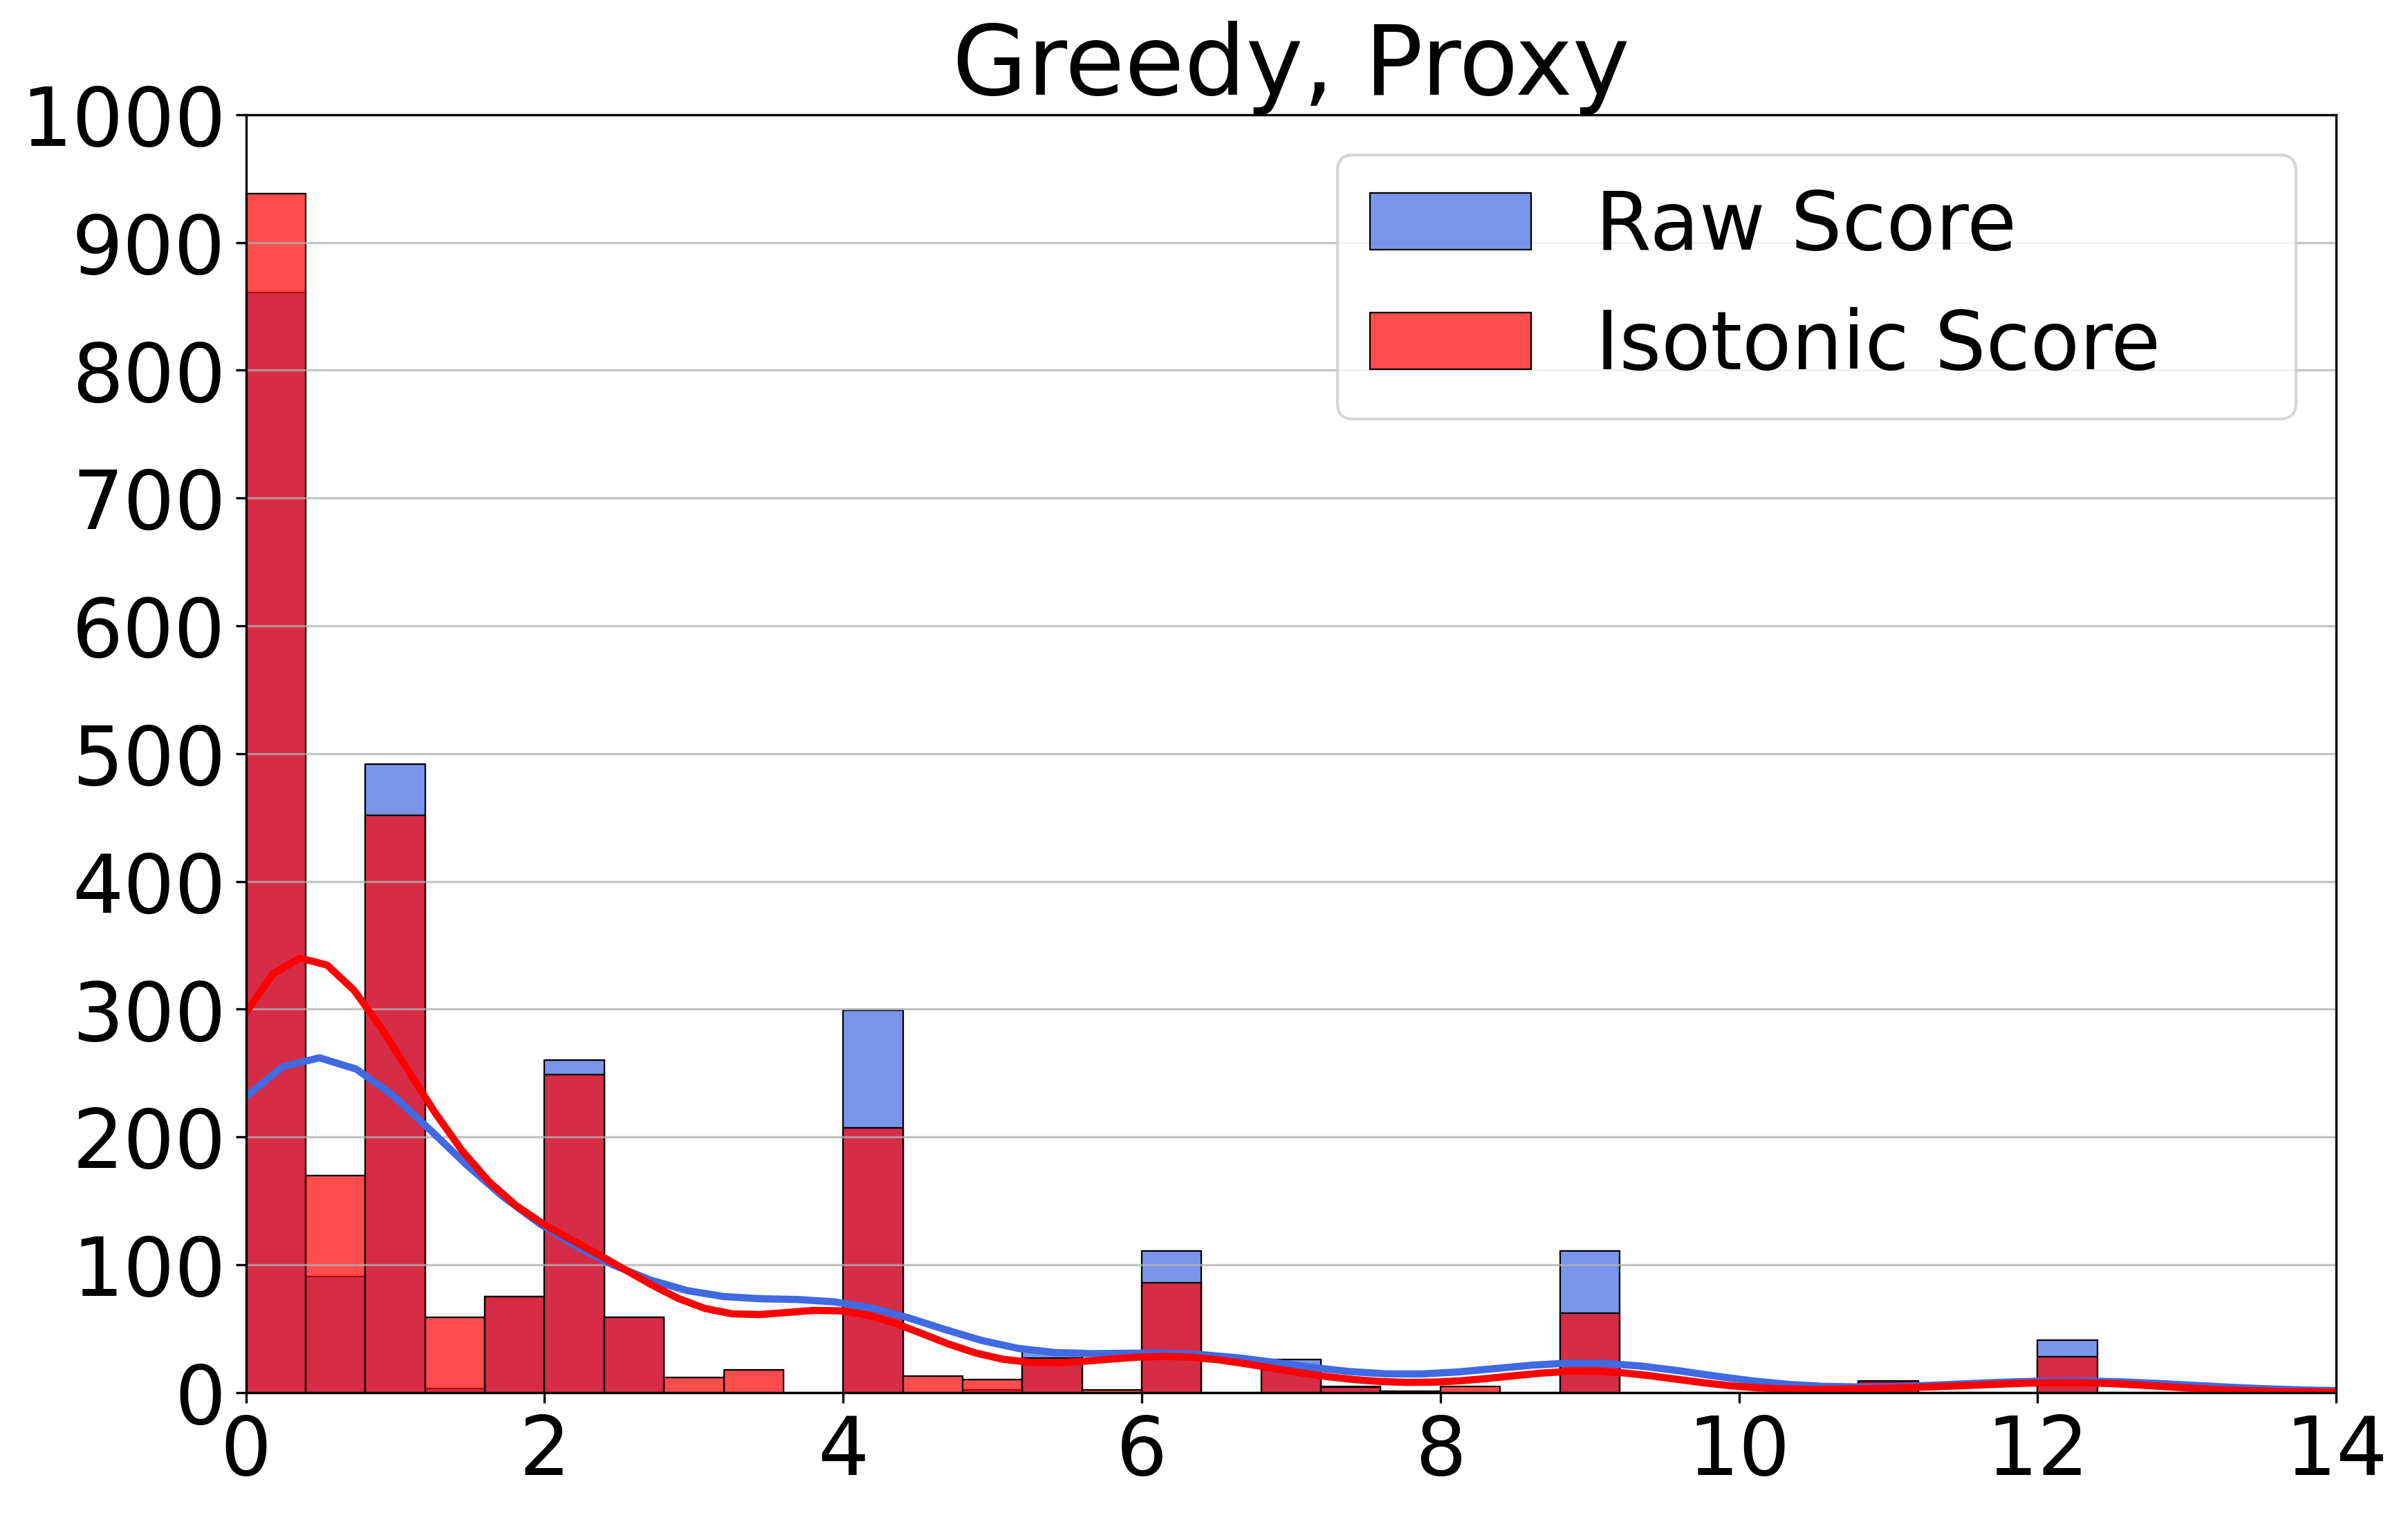

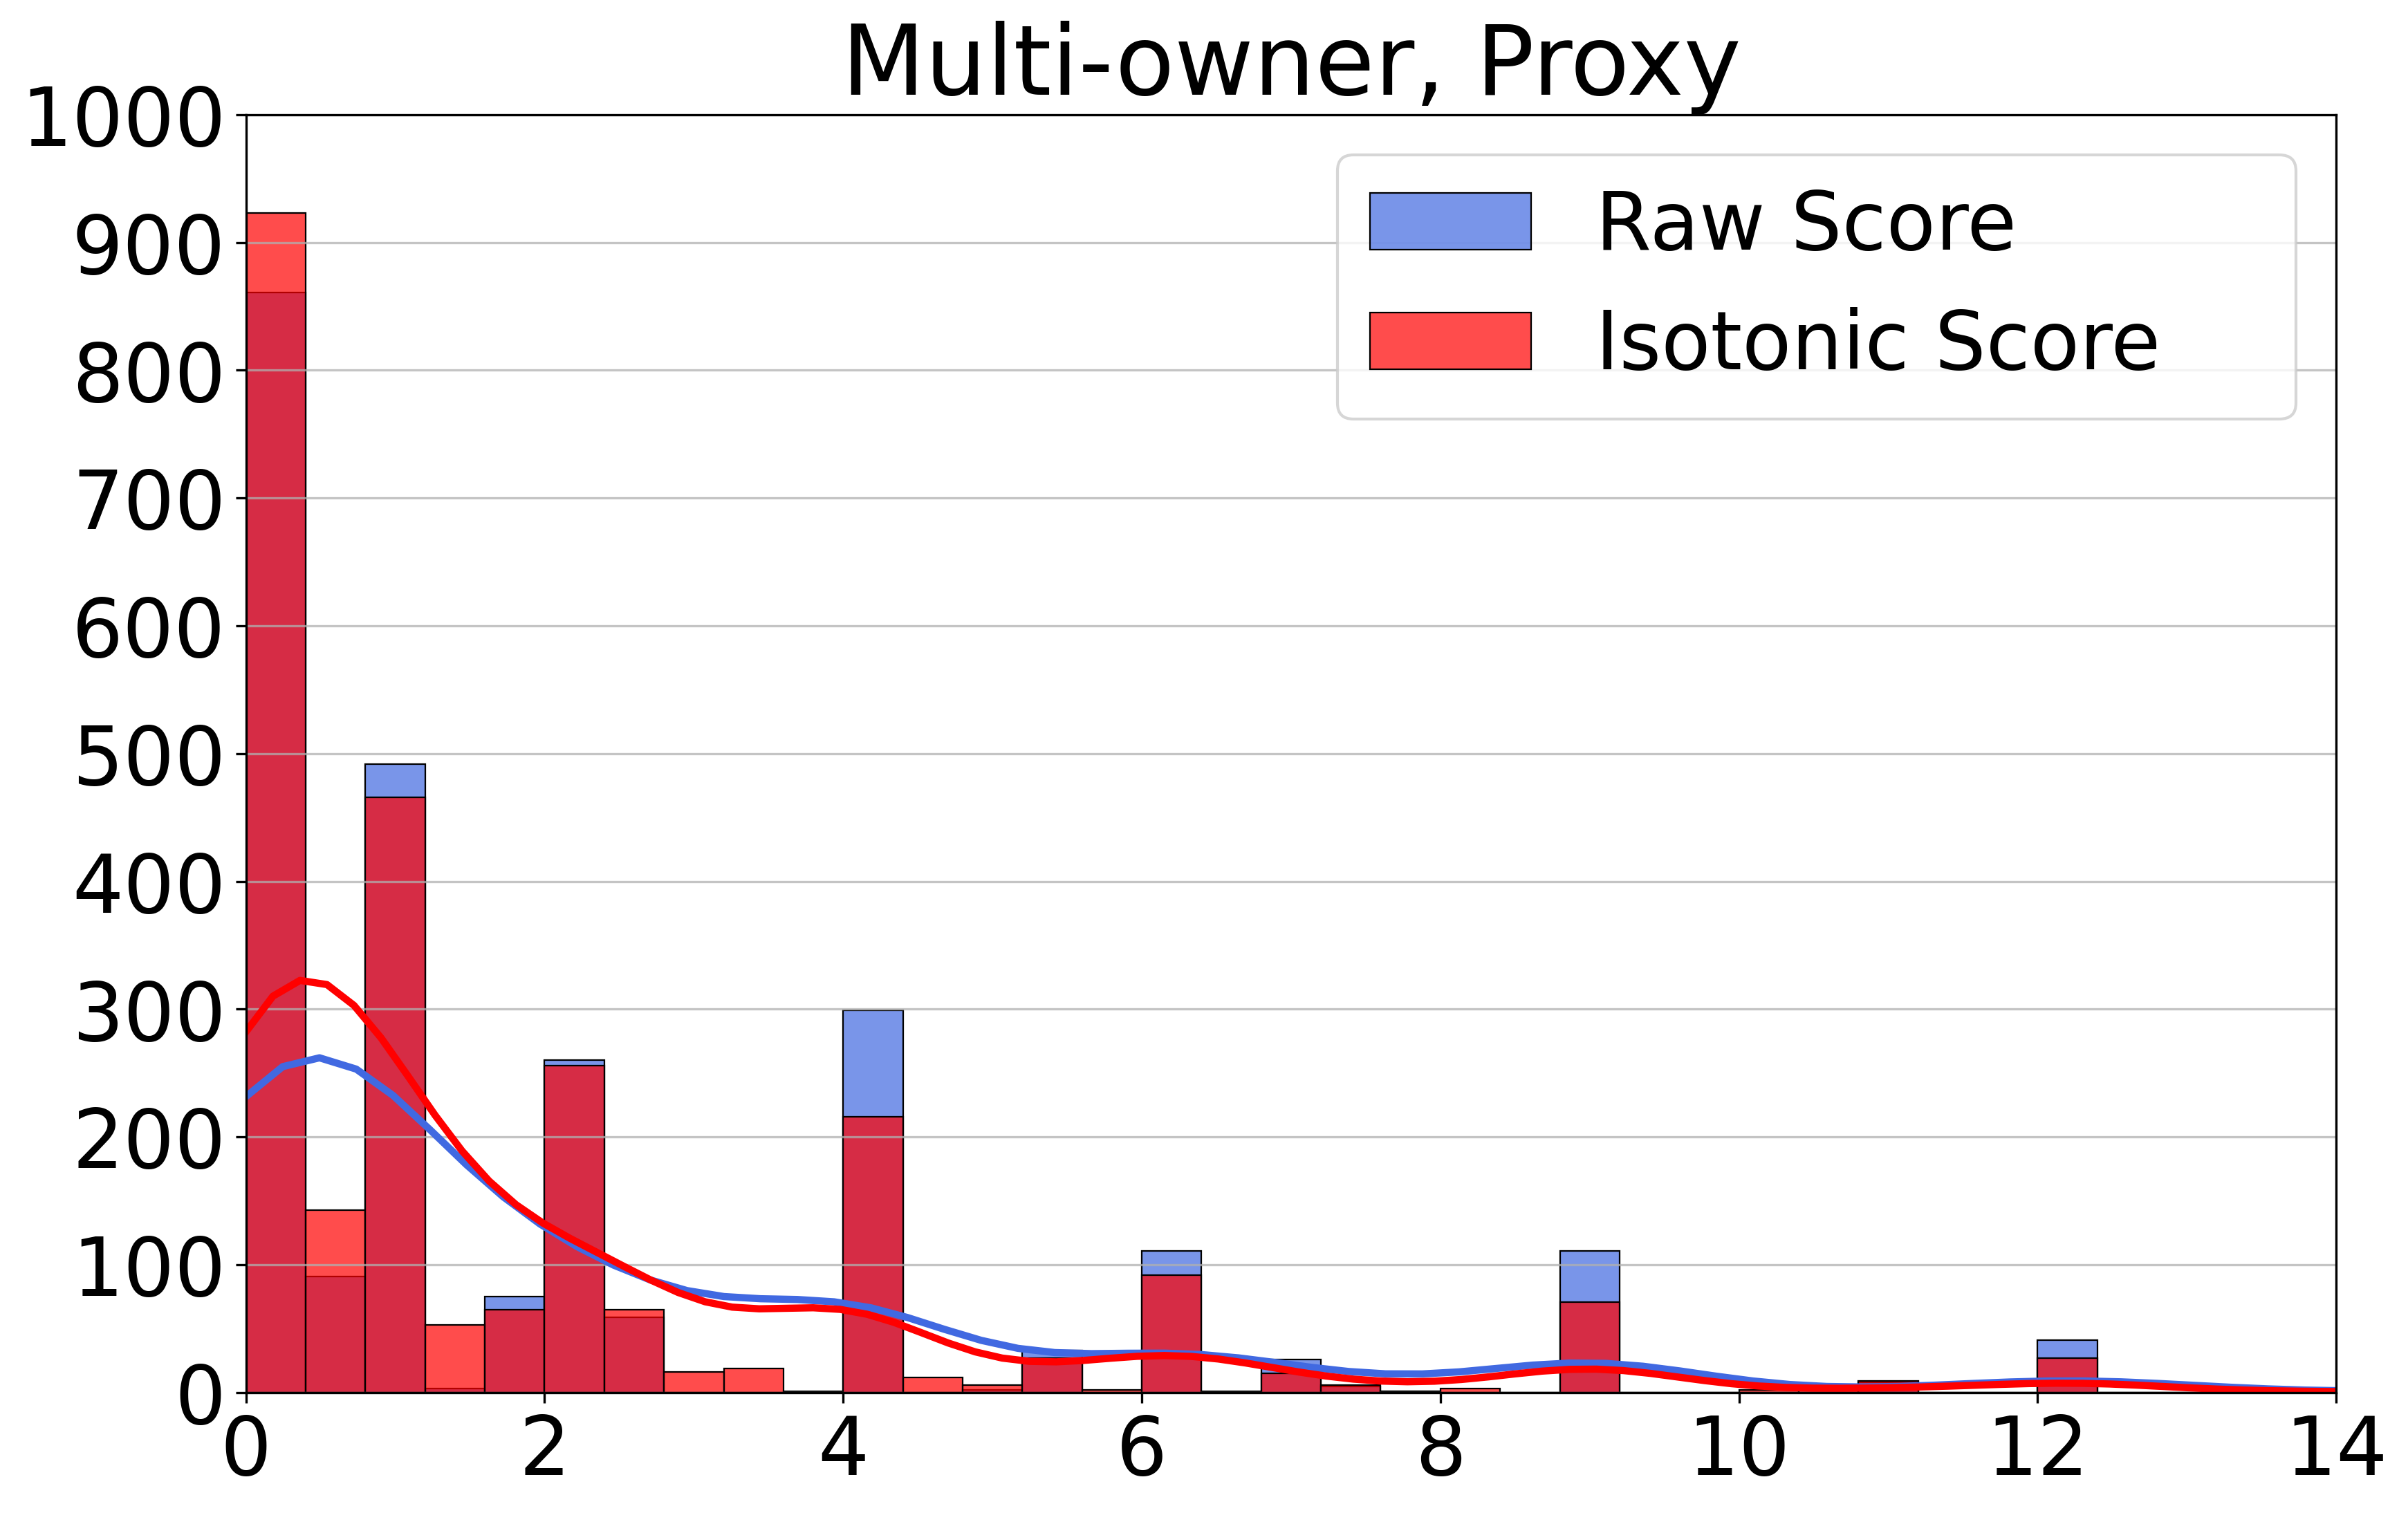

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug  8 21:20:29 2023

@author: buxinsu
"""
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch



def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()


	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


'''
MULTIOWNER ISOTONIC
'''
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/proxy_score.csv')

df = df.drop_duplicates(['submission_idx', 'author_idx'])


# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()

submissions = df['submission_idx'].unique()


author_submission = {}
# Loop through every submission
for author in authors:

    # Extract the rating as sets
    submissionss = list( set(df[df['author_idx'] == author]['submission_idx'].tolist()) )

    # Add the ratings to the results dictionary
    author_submission[author] = submissionss



m_2 = len(author_submission)
n_2 = len(submissions)

'''
authors = [
    {
        paper_idx : ranking,
        ...
    },
    ...
]
'''
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())

partition, author_parts = arbitrary(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)




# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers

  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)





  author_submission_rank_multi_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

      author_submission_rank_multi_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))




  submission_multi_iso_rating = {}
  for submission in paper_part:
      submission_multi_iso_rating[submission] = []

  for author in author_submission_rank_multi_iso:
      for i in range(len(author_submission_rank_multi_iso[author])):
          submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

  for submission in submission_multi_iso_rating:
      # Convert string numbers to float
      submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]

      avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])

      submission_multi_iso_rating[submission] = avg_rating


  for i in paper_part:
    calibrated_scores[i] = submission_multi_iso_rating[i]



multi_iso_rating = []
for i in range(n_2):
  multi_iso_rating.append(calibrated_scores[i])



'''
GREEDY ISOTONIC
'''

partition, author_parts = greedy(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
#
#

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)




  author_submission_rank_greedy_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

      author_submission_rank_greedy_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))


  submission_greedy_iso_rating = {}
  for submission in paper_part:
      submission_greedy_iso_rating[submission] = []

  for author in author_submission_rank_greedy_iso:
      for i in range(len(author_submission_rank_greedy_iso[author])):
          submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

  for submission in submission_greedy_iso_rating:
      # Convert string numbers to float
      submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]

      avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])

      submission_greedy_iso_rating[submission] = avg_rating



  for i in paper_part:
    calibrated_scores[i] = submission_greedy_iso_rating[i]




greedy_iso_rating = []
for i in range(n_2):
  greedy_iso_rating.append(calibrated_scores[i])



submission_true_rating = {}
for submission in range(n_2):
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for i in range(n_2):
    True_score_multi_iso.append(submission_true_rating[i])



old_rating = {}
for submission in range(n_2):
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for i in range(n_2):
    old_score_multi_iso.append(old_rating[i])



print('Greedy Isotonic Mechanism', mean_squared_error(greedy_iso_rating, True_score_multi_iso, squared=False))
print('Multiowner Isotonic Mechanism', mean_squared_error(multi_iso_rating, True_score_multi_iso, squared=False))
#print('Singal Isotonic Mechanism:', mean_squared_error(iso_rating, True_score, squared=False))
print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso, squared=False))


greedy_diff = []
multi_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  greedy_diff.append( (greedy_iso_rating[i] - True_score_multi_iso[i])**2 )
  multi_diff.append( (multi_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )


#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_ind(old_diff, greedy_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)


#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_ind(old_diff, multi_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for multi-owner:", t_statistic)
print("Before Rebuttal with proxy p-value for multi-owner:", p_value)




# 做一个histogram
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=True, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Isotonic Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
# sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='After Single Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('(b) Squared Error')
plt.ylabel('')
plt.title('Greedy, Proxy')
plt.xlim(0, 14)
plt.yticks(range(0, 1001, 100))
plt.legend()
plt.savefig('/content/drive/MyDrive/Research/Ranking_ICML/Figures/greedy_iso_proxy_histo.svg', bbox_inches='tight')
plt.show()

# 做一个histogram
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=True, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
#sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Multi Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Isotonic Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('(c) Squared Error')
plt.ylabel('')
plt.title('Multi-owner, Proxy')
plt.xlim(0, 14)
plt.yticks(range(0, 1001, 100))
plt.legend()
plt.savefig('/content/drive/MyDrive/Research/Ranking_ICML/Figures/multiowner_iso_proxy_histo.svg', bbox_inches='tight')
plt.show()


Isotonic Mechanism for Rating Before Rebuttal and fuzzy proxy


Ad-hoc Isotonic Mechanism 1.5211989289771046
Review Rating 1.5980043150397347
Before Rebuttal with proxy t-test for greedy: 2.369750498769292
Before Rebuttal with proxy p-value for greedy: 0.008921466374564955


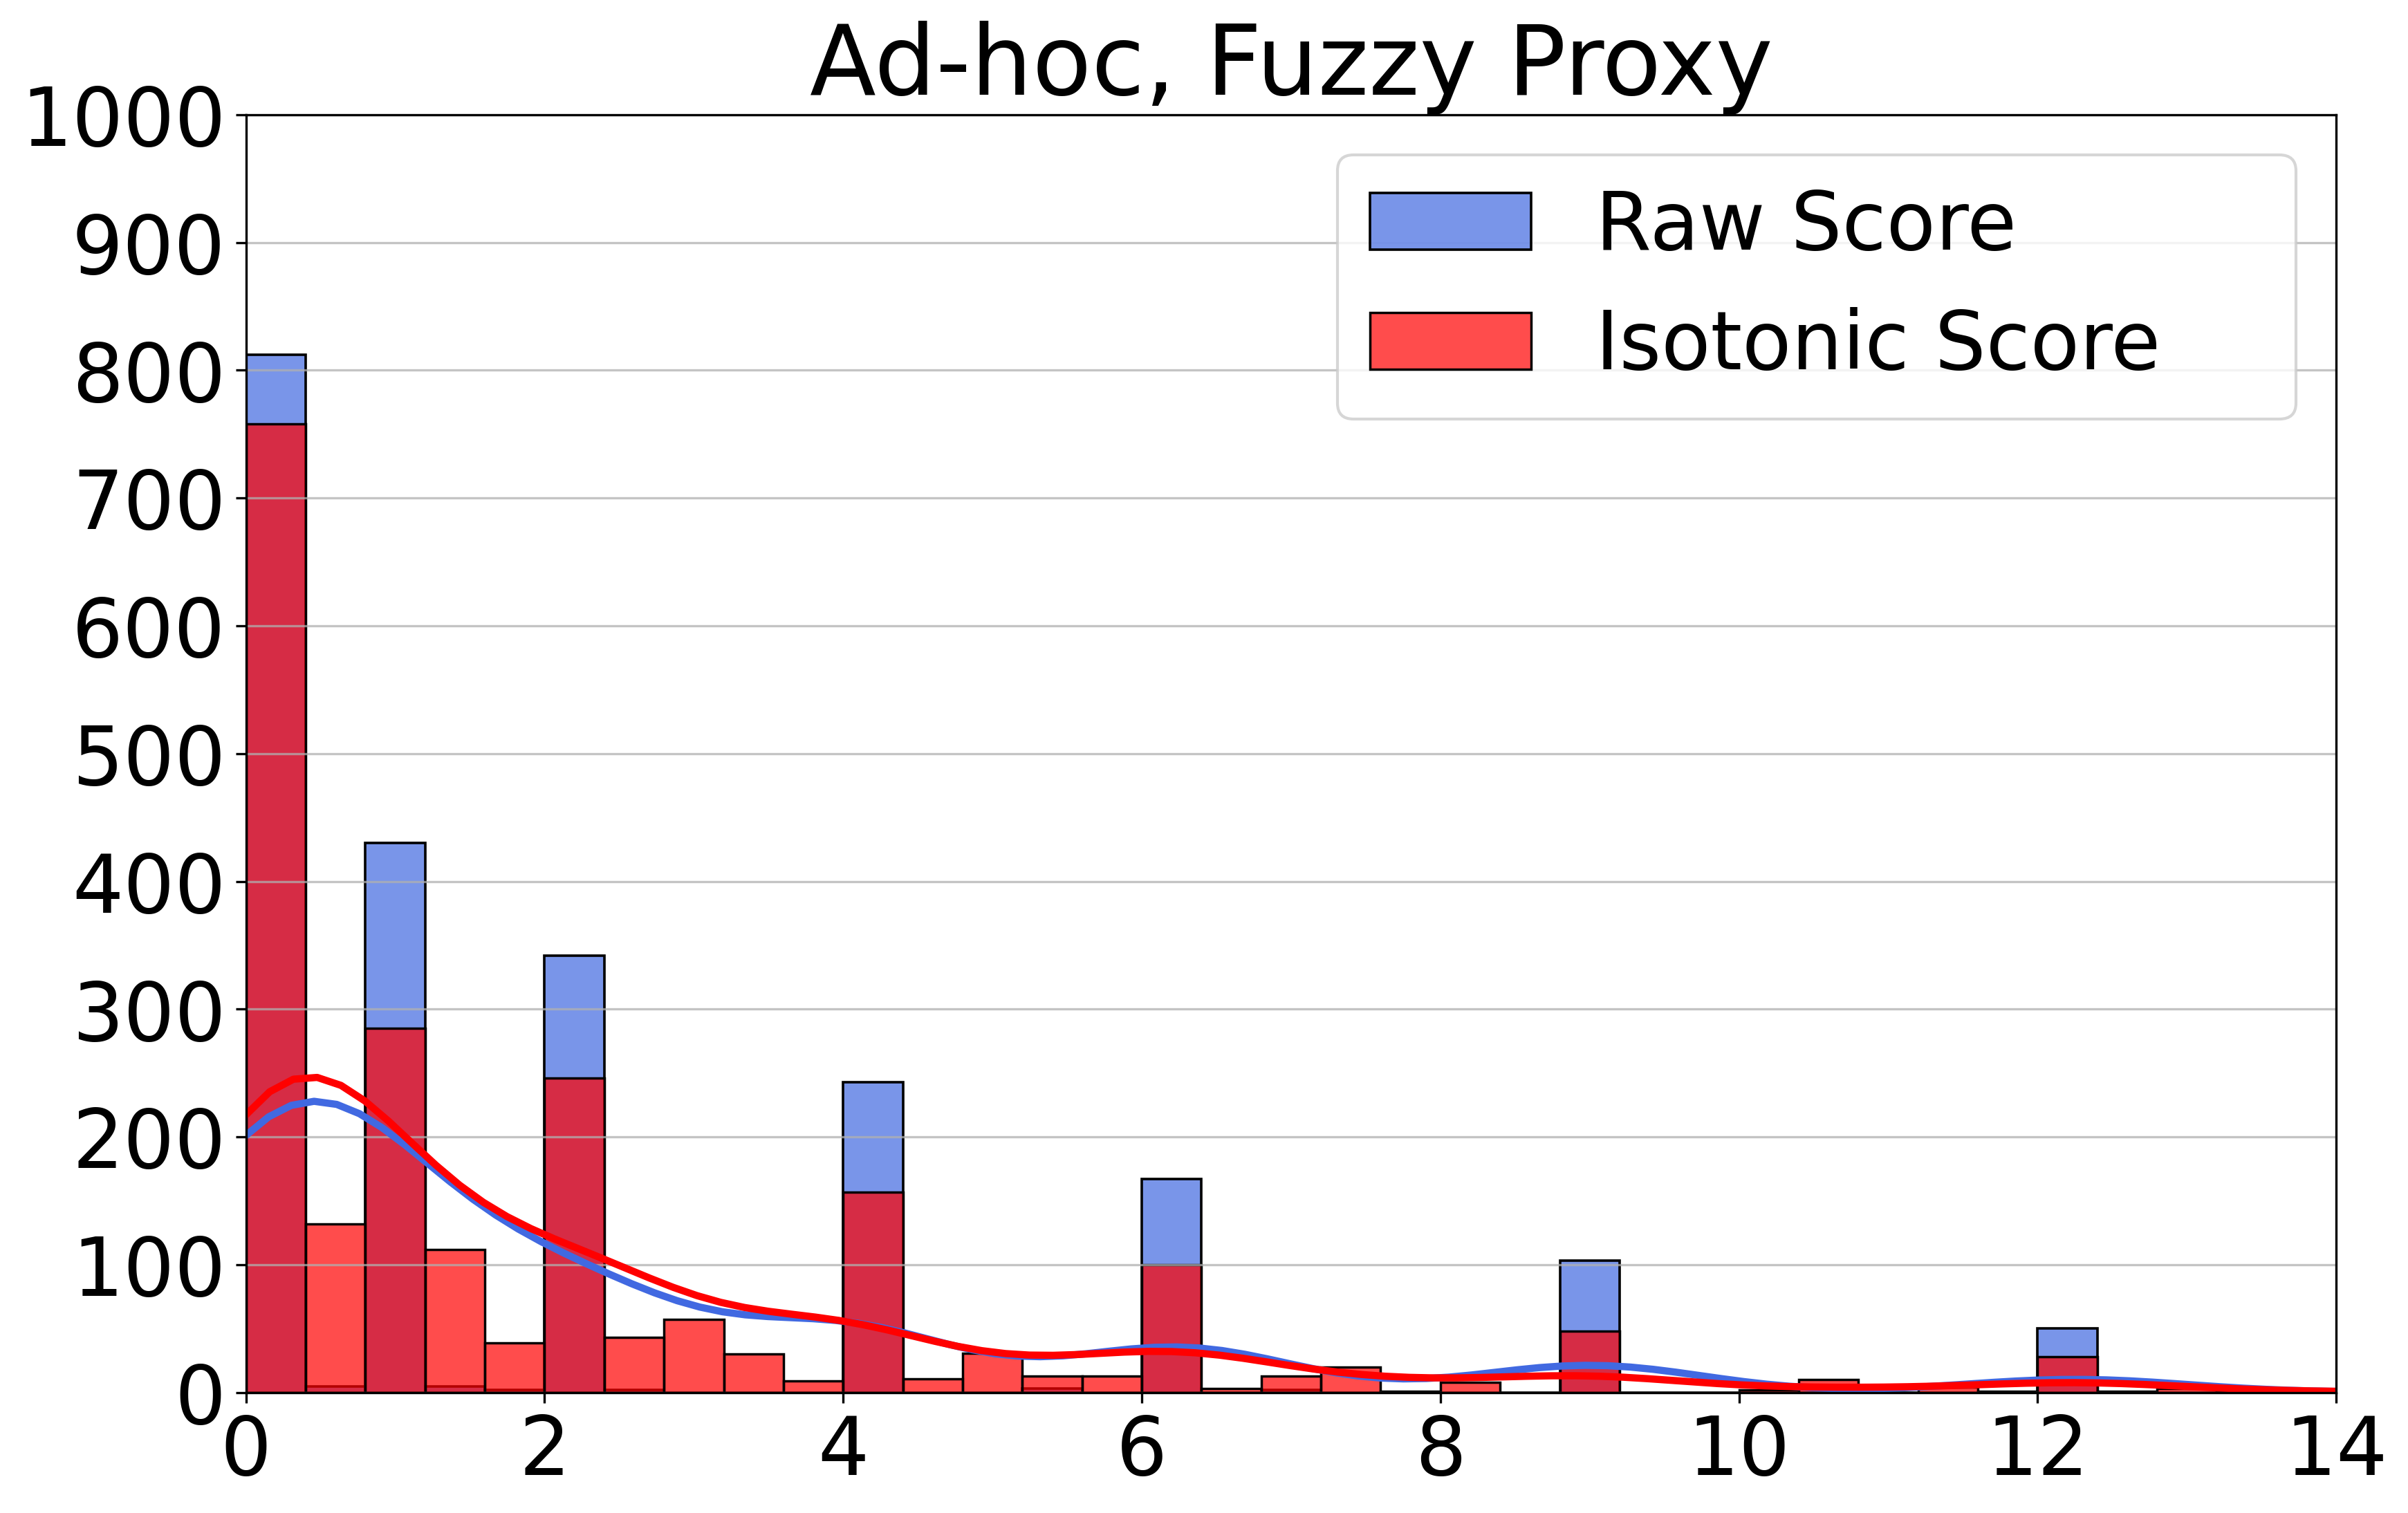

In [9]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch



# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/fuzzy_proxy_score.csv')

df = df.drop_duplicates(['submission_idx', 'author_idx'])



# For each author, list its ranked submissions according to its ranking

author_submission_rank_old = {}

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()

# Loop through every submission
for author in authors:

    author_submission_rank_old[author] = []

    # Extract the rating as sets
    submissions = list(set(df[df['author_idx'] == author]['submission_idx'].tolist()))

    for i in range(len(submissions)):

        rank = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((submissions[i], rank, ratings))

def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

author_submission_rank_old = sort_submissions(author_submission_rank_old)




author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))




final_submission_list = df['submission_idx'].unique()



submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    # Convert string numbers to float
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating



adhoc_iso_rating = []
for submission in final_submission_list:
  adhoc_iso_rating.append(submission_new_rating[submission])




submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for submission in final_submission_list:
    True_score_multi_iso.append(submission_true_rating[submission])



old_rating = {}
for submission in final_submission_list:
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for submission in final_submission_list:
    old_score_multi_iso.append(old_rating[submission])



print('Ad-hoc Isotonic Mechanism', mean_squared_error(adhoc_iso_rating, True_score_multi_iso, squared=False))
print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso, squared=False))



adhoc_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  adhoc_diff.append( (adhoc_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_ind(old_diff, adhoc_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)



# 做一个histogram
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=True, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
#sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Multi Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=adhoc_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Isotonic Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('(d) Squared Error')
plt.ylabel('')
plt.title('Ad-hoc, Fuzzy Proxy')
plt.xlim(0, 14)
plt.yticks(range(0, 1001, 100))
plt.legend()
plt.savefig('/content/drive/MyDrive/Research/Ranking_ICML/Figures/adhoc_iso_fuzzy_proxy_histo.svg', bbox_inches='tight')
plt.show()

Greedy Isotonic Mechanism 1.5304525978019885
Multiowner Isotonic Mechanism 1.5358236853730949
Review Rating 1.5980043150397347
Before Rebuttal with proxy t-test for greedy: 2.06811711720333
Before Rebuttal with proxy p-value for greedy: 0.01934361816903344
Before Rebuttal with proxy t-test for multi-owner: 1.909732478040831
Before Rebuttal with proxy p-value for multi-owner: 0.0281162699009012


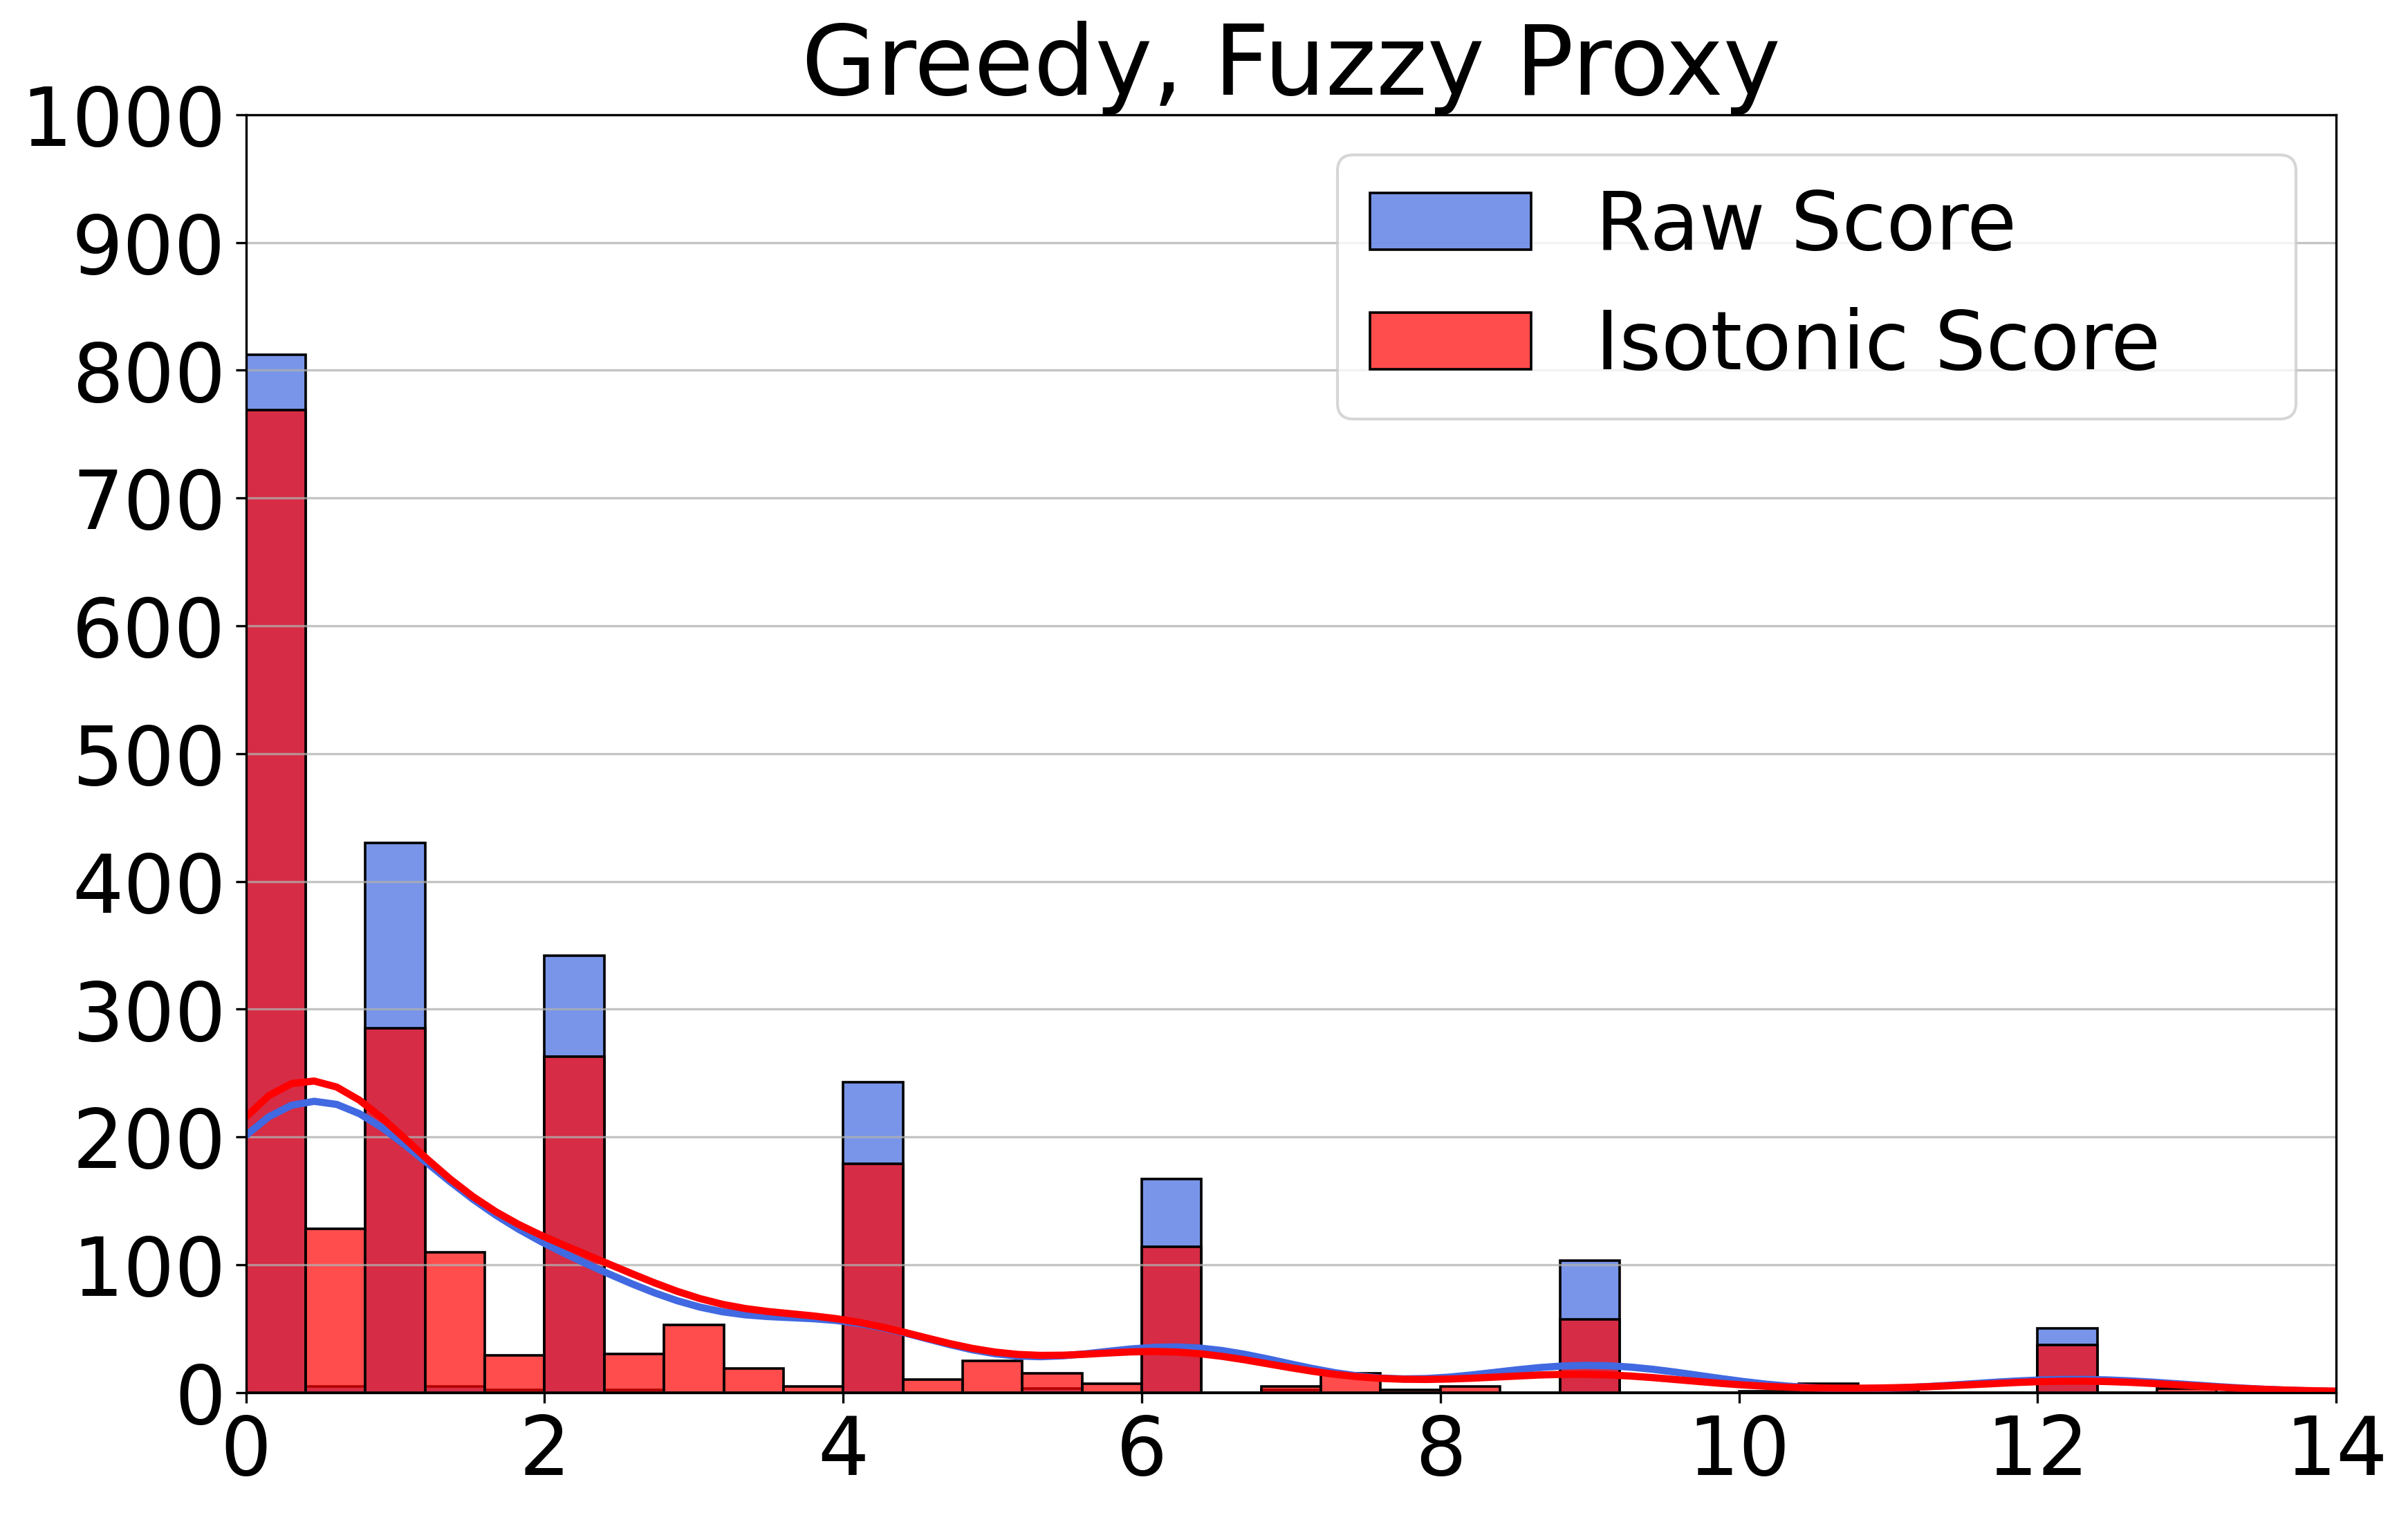

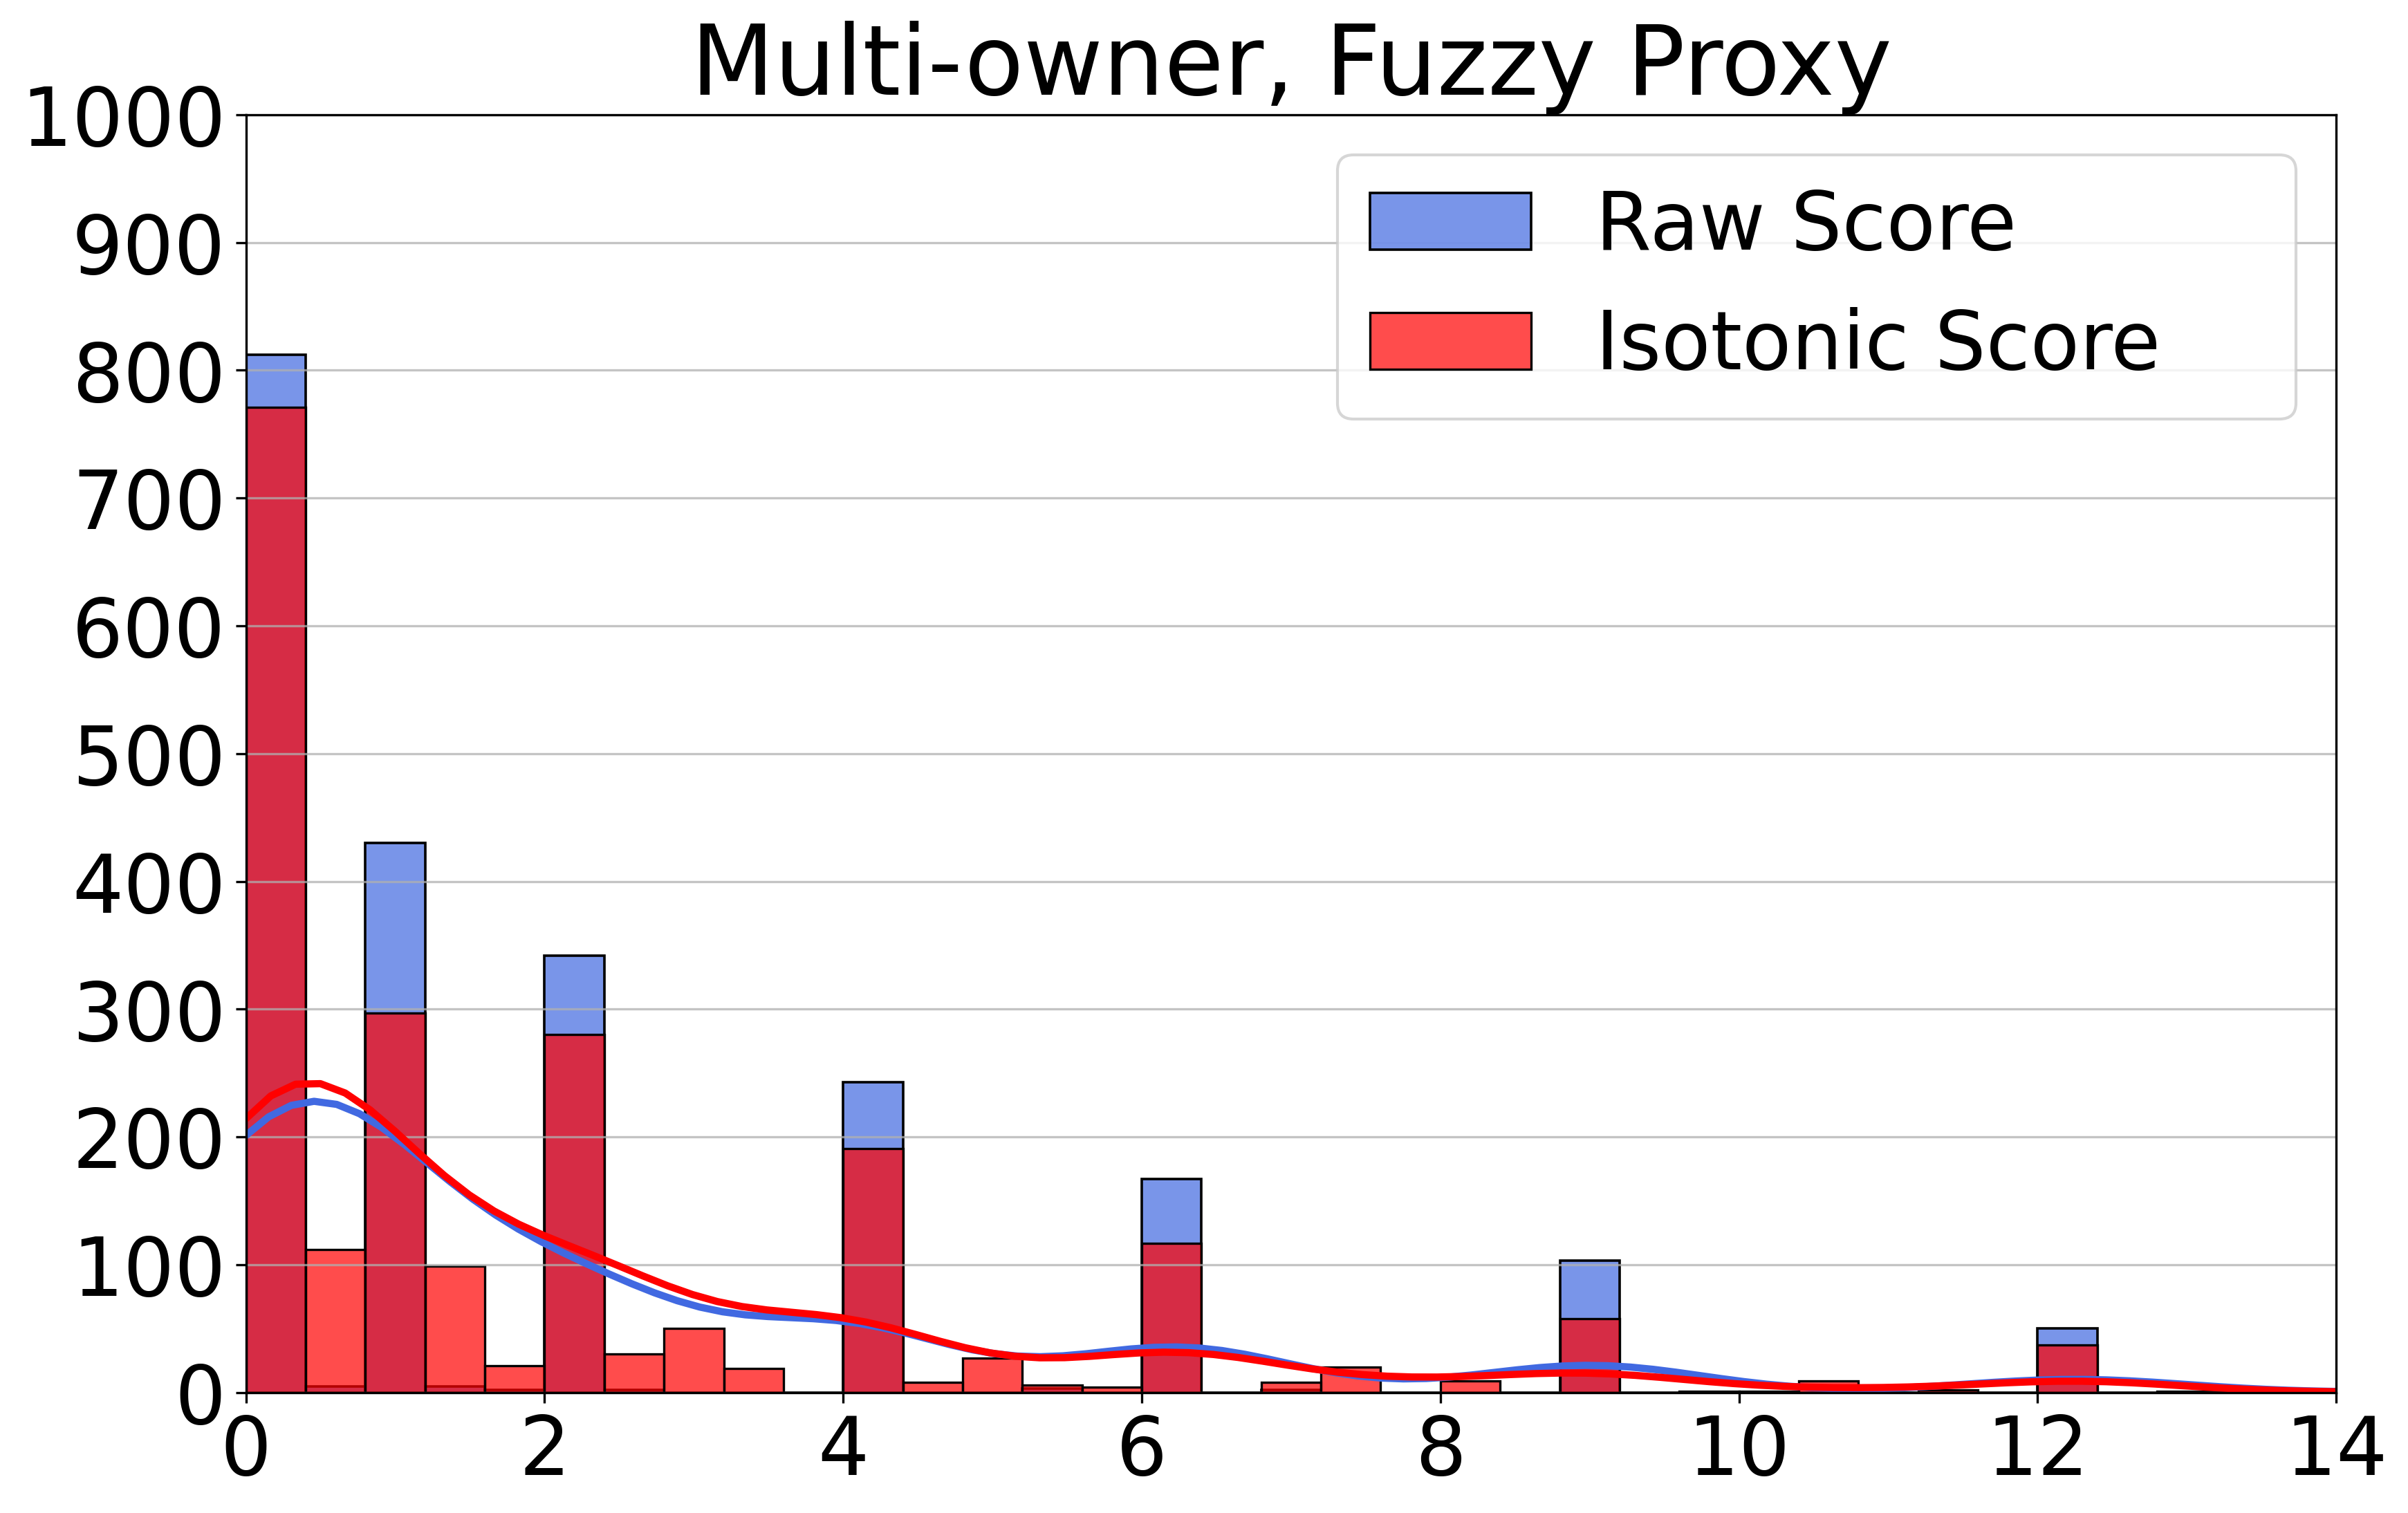

In [10]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch

def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()


	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


'''
MULTIOWNER ISOTONIC
'''
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/fuzzy_proxy_score.csv')

df = df.drop_duplicates(['submission_idx', 'author_idx'])

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()
submissions = df['submission_idx'].unique()

author_submission = {}
# Loop through every submission
for author in authors:

    # Extract the rating as sets
    submissionss = df[df['author_idx'] == author]['submission_idx'].tolist()

    # Add the ratings to the results dictionary
    author_submission[author] = submissionss



m_2 = len(author_submission)
n_2 = len(submissions)

'''
authors = [
    {
        paper_idx : ranking,
        ...
    },
    ...
]
'''
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())

partition, author_parts = arbitrary(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)





  author_submission_rank_multi_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)


      author_submission_rank_multi_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))




  submission_multi_iso_rating = {}
  for submission in paper_part:
      submission_multi_iso_rating[submission] = []

  for author in author_submission_rank_multi_iso:
      for i in range(len(author_submission_rank_multi_iso[author])):
          submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

  for submission in submission_multi_iso_rating:
      # Convert string numbers to float
      submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]

      avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])

      submission_multi_iso_rating[submission] = avg_rating



  for i in paper_part:
    calibrated_scores[i] = submission_multi_iso_rating[i]



multi_iso_rating = []
for i in range(n_2):
  multi_iso_rating.append(calibrated_scores[i])




'''
GREEDY ISOTONIC
'''

partition, author_parts = greedy(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)




  author_submission_rank_greedy_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)


      author_submission_rank_greedy_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))




  submission_greedy_iso_rating = {}
  for submission in paper_part:
      submission_greedy_iso_rating[submission] = []

  for author in author_submission_rank_greedy_iso:
      for i in range(len(author_submission_rank_greedy_iso[author])):
          submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

  for submission in submission_greedy_iso_rating:
      # Convert string numbers to float
      submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]

      avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])

      submission_greedy_iso_rating[submission] = avg_rating




  for i in paper_part:
    calibrated_scores[i] = submission_greedy_iso_rating[i]




greedy_iso_rating = []
for i in range(n_2):
  greedy_iso_rating.append(calibrated_scores[i])



submission_true_rating = {}
for submission in range(n_2):
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for i in range(n_2):
    True_score_multi_iso.append(submission_true_rating[i])



old_rating = {}
for submission in range(n_2):
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for i in range(n_2):
    old_score_multi_iso.append(old_rating[i])



print('Greedy Isotonic Mechanism', mean_squared_error(greedy_iso_rating, True_score_multi_iso, squared=False))
print('Multiowner Isotonic Mechanism', mean_squared_error(multi_iso_rating, True_score_multi_iso, squared=False))
#print('Singal Isotonic Mechanism:', mean_squared_error(iso_rating, True_score, squared=False))
print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso, squared=False))




greedy_diff = []
multi_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  greedy_diff.append( (greedy_iso_rating[i] - True_score_multi_iso[i])**2 )
  multi_diff.append( (multi_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )


#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_ind(old_diff, greedy_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)


#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_ind(old_diff, multi_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for multi-owner:", t_statistic)
print("Before Rebuttal with proxy p-value for multi-owner:", p_value)




# 做一个histogram
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=True, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Isotonic Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
# sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='After Single Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )




# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('(e) Squared Error')
plt.ylabel('')
plt.title('Greedy, Fuzzy Proxy')
plt.xlim(0, 14)
plt.yticks(range(0, 1001, 100))
plt.legend()
plt.savefig('/content/drive/MyDrive/Research/Ranking_ICML/Figures/greedy_iso_fuzzy_proxy_histo.svg', bbox_inches='tight')
plt.show()


# 做一个histogram
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=True, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
#sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Greedy Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=True, label='Isotonic Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )


# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('(f) Squared Error')
plt.ylabel('')
plt.title('Multi-owner, Fuzzy Proxy')
plt.xlim(0, 14)
plt.yticks(range(0, 1001, 100))
plt.legend()
plt.savefig('/content/drive/MyDrive/Research/Ranking_ICML/Figures/multiowner_iso_fuzzy_proxy_histo.svg', bbox_inches='tight')
plt.show()


